# Traffic sign recognition using Tensorflow 

For training I am using German sign dataset which can be found here: http://benchmark.ini.rub.de/

In [3]:
import os
import random
import csv
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from keras.preprocessing.image import ImageDataGenerator
import cv2

Using TensorFlow backend.


Setting path to train and test data.

In [2]:
ROOT_PATH = "./datasets"
TRAIN_DATA_DIR = os.path.join(ROOT_PATH, "training_images/Final_Training/Images/")
TEST_DATA_DIR = os.path.join(ROOT_PATH, "testing_dataset/Final_Test/Images/")
IMAGE_WIDTH = 32
IMAGE_LENGTH = 32
COLOR_CHANNELS = 3

In [3]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
TRAIN_STEPS = 150

Loading train data.

In [4]:
def resize_image(path):
    return resize(plt.imread(path), (IMAGE_WIDTH, IMAGE_LENGTH))

In [ ]:
def reshape_image(image_array):
    return image_array.reshape(IMAGE_WIDTH * IMAGE_LENGTH * COLOR_CHANNELS)

In [5]:
def load_train_data(data_dir):
    directories = [d for d in os.listdir(data_dir)
                  if os.path.isdir(os.path.join(data_dir, d))]
    labels = []
    images = []
            
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        label_file_names = [os.path.join(label_dir, f)
                        for f in os.listdir(label_dir) if f.endswith(".ppm")]
        
        for image in label_file_names:
            resized_image = resize_image(image)
            images.append(resized_image)
            #images.append(reshape_image(resized_image))
            labels.append(int(d))
            
    return labels, images

Loading test data.

In [6]:
def load_test_data(data_dir):
    csv_file = open(data_dir + 'GT-final_test.csv')
    
    labels = []
    images = []
    
    reader = csv.reader(csv_file, delimiter=';')
    reader.next()   #skip header row
    for row in reader:
        resized_image = resize_image(data_dir + row[0])
        images.append(resized_image)
        #images.append(reshape_image(resized_image))
        labels.append(int(row[7]))
    csv_file.close()
    return labels, images

In [7]:
train_labels, train_images = load_train_data(TRAIN_DATA_DIR)
val_labels, val_images = load_test_data(TEST_DATA_DIR)

In [8]:
train_labels_arr = np.array(train_labels)
train_images_arr = np.array(train_images)

In [9]:
val_labels_arr = np.array(val_labels)
val_images_arr = np.array(val_images)

Image generator used to generate new samples with keras lib

In [ ]:
datagen = ImageDataGenerator(rotation_range=17,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=False)

In [ ]:
for keras_gen_images, keras_gen_labels in datagen.flow(train_images_arr, train_labels_arr,
                                             batch_size=len(train_labels), shuffle=False):
    break

In [ ]:
train_labels_arr = np.concatenate((train_labels_arr, keras_gen_labels))
train_images_arr = np.concatenate((train_images_arr, keras_gen_images))

Generating blur images with OpenCV GaussianBlur

In [ ]:
def generate_blur_images(train_images):
    blur_images = []

    images_count = len(train_images)

    for i in range(images_count):
        blur_images.append(cv2.GaussianBlur(train_images[i], (5, 5), 0.7))
    
    return np.array(blur_images)

blur_images = generate_blur_images(train_images)

In [ ]:
train_labels_arr = np.concatenate((train_labels_arr, np.array(train_labels)))
train_images_arr = np.concatenate((train_images_arr, blur_images))

In [ ]:
index = random.sample(xrange(len(train_images_arr)), 9)

In [ ]:
plt.figure(figsize=(6,6))

for i in range(0, 9):
    plt.subplot(331 + i)
    plt.imshow(train_images_arr[index[i]])
#plt.savefig('expore_training_data.png')
plt.show()

plt.figure(figsize=(6,6))
for i in range(0, 9):
    plt.subplot(331 + i)
    plt.imshow(keras_gen_images[index[i]])
#plt.savefig('expore_keras_data.png')
plt.show()

Creating bar chart for dataset Visualization.

In [ ]:
def draw_data_chart(train_labels, save_name):
    data = np.unique(train_labels_arr, return_counts=True)[1]
   
    plt.figure(figsize=(20, 10))

    y_pos = np.arange(len(data))

    plt.bar(y_pos, data, align='center', alpha = 0.5)
    plt.xticks(y_pos, y_pos)
    plt.axis('tight')
    plt.savefig(save_name)
    plt.show()

In [ ]:
draw_data_chart(train_labels_arr, './chart_figures/train_data.png')
draw_data_chart(val_labels_arr, './chart_figures/test_data.png')

Functions used for creating a convolutional and pooling layers

In [10]:
def conv2d(input_layer, filters, padding):
    return tf.layers.conv2d(
        inputs=input_layer,
        filters=filters,
        kernel_size=(5, 5),
        padding=padding,
        activation=tf.nn.elu)

def pooling(input_layer):
    return tf.layers.max_pooling2d(
        inputs=input_layer, 
        pool_size=(2, 2), 
        strides=(2, 2),
        padding='same')

In [11]:
with tf.device("/device:GPU:0"):    
    images = tf.placeholder(tf.float32, [None, IMAGE_WIDTH , IMAGE_LENGTH, COLOR_CHANNELS], name = "images")
    labels = tf.placeholder(tf.int32, [None])
    
    one_hot_labels = tf.one_hot(labels, len(set(train_labels_arr)))
    conv1 = conv2d(images, 12, 'valid')
    pool1 = pooling(conv1)
    
    conv2 = conv2d(pool1, 24, 'valid')
    pool2 = pooling(conv2)
    
    flat = tf.layers.flatten(pool2)
    dropout = tf.layers.dropout(inputs=flat, rate=0.5)

    dense = tf.layers.dense(dropout, 512, tf.nn.elu)
    
    logits = tf.layers.dense(dense, len(set(train_labels_arr)), tf.nn.elu)
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_labels, logits=logits)
    loss = tf.reduce_mean(cross_entropy)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)
    
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_labels, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    prediction = tf.argmax(logits, 1, name="prediction")

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()

In [12]:
saver = tf.train.Saver()
session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session.run(init_g)
session.run(init_l)
tf.train.write_graph(session.graph_def, './model/', 'model.pb', as_text=False)

'./model/model.pb'

Validation function

In [13]:
def validation(val_images, val_labels):
    return session.run(accuracy, { images: val_images, labels: val_labels })

Function for logging data during training

In [14]:
def training_log(steps, val_acc, training_time):
    print('Step: {}'.format(steps))
    print('Validation accuracy: {0:.2f}%'
          .format(val_acc))
    minutes, seconds = divmod(training_time, 60)
    hours, minutes = divmod(minutes, 60)
    print('Traning time: {0:02.0f}:{1:02.0f}:{2:05.2f}\n'.format(hours, minutes, seconds))

In [15]:
def draw_accuracy_chart(training_data):
    steps, accuracy = zip(*training_data)
    plt.figure(figsize=(20, 10))
    plt.subplot(111)

    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Steps')
    plt.plot(steps, accuracy)
    
    plt.savefig('train_log.png')
    plt.show()

Step: 0
Validation accuracy: 0.07%
Traning time: 00:01:36.45

Step: 1
Validation accuracy: 0.05%
Traning time: 00:01:54.54

Step: 2
Validation accuracy: 0.06%
Traning time: 00:02:10.94

Step: 3
Validation accuracy: 0.07%
Traning time: 00:02:27.24

Step: 4
Validation accuracy: 0.09%
Traning time: 00:02:43.56

Step: 5
Validation accuracy: 0.08%
Traning time: 00:03:00.13

Step: 6
Validation accuracy: 0.09%
Traning time: 00:03:16.52

Step: 7
Validation accuracy: 0.10%
Traning time: 00:03:32.75

Step: 8
Validation accuracy: 0.12%
Traning time: 00:03:48.95

Step: 9
Validation accuracy: 0.12%
Traning time: 00:04:05.18

Step: 10
Validation accuracy: 0.13%
Traning time: 00:04:21.33

Step: 11
Validation accuracy: 0.14%
Traning time: 00:04:37.56

Step: 12
Validation accuracy: 0.14%
Traning time: 00:04:53.76

Step: 13
Validation accuracy: 0.17%
Traning time: 00:05:09.95

Step: 14
Validation accuracy: 0.16%
Traning time: 00:05:26.17

Step: 15
Validation accuracy: 0.18%
Traning time: 00:05:42.34

St

Step: 130
Validation accuracy: 0.93%
Traning time: 00:37:51.95

Step: 131
Validation accuracy: 0.93%
Traning time: 00:38:09.05

Step: 132
Validation accuracy: 0.93%
Traning time: 00:38:25.79

Step: 133
Validation accuracy: 0.93%
Traning time: 00:38:43.29

Step: 134
Validation accuracy: 0.93%
Traning time: 00:39:00.97

Step: 135
Validation accuracy: 0.93%
Traning time: 00:39:17.77

Step: 136
Validation accuracy: 0.93%
Traning time: 00:39:36.15

Step: 137
Validation accuracy: 0.93%
Traning time: 00:39:54.32

Step: 138
Validation accuracy: 0.93%
Traning time: 00:40:11.42

Step: 139
Validation accuracy: 0.93%
Traning time: 00:40:28.36

Step: 140
Validation accuracy: 0.93%
Traning time: 00:40:45.07

Step: 141
Validation accuracy: 0.93%
Traning time: 00:41:01.62

Step: 142
Validation accuracy: 0.93%
Traning time: 00:41:18.03

Step: 143
Validation accuracy: 0.92%
Traning time: 00:41:34.41

Step: 144
Validation accuracy: 0.92%
Traning time: 00:41:51.13

Step: 145
Validation accuracy: 0.93%
Tra

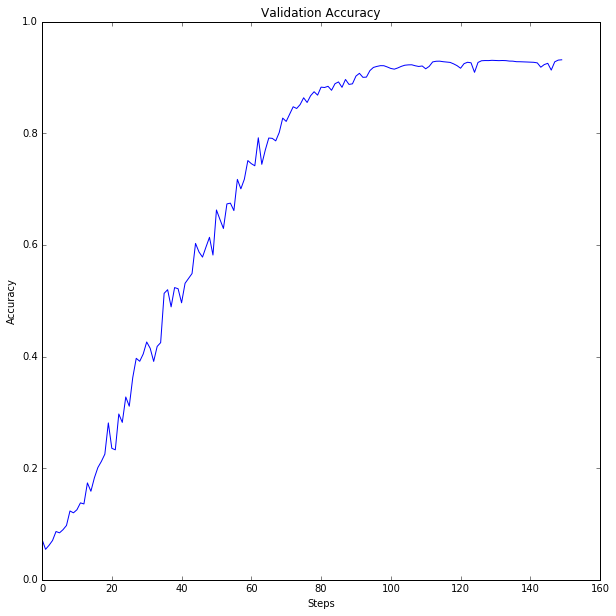

In [16]:
def train_model(training_images, training_labels, val_images, val_labels, steps):
    t_start = time.time()
    prev_val_accuracy = 0
    training_data = []
    
    for step in range(steps):
        for i in range(0, len(training_images), BATCH_SIZE):
            slice_end = i + BATCH_SIZE
            batch_images = training_images[i:slice_end]
            batch_labels = training_labels[i:slice_end]
            
            session.run(optimizer, feed_dict={ images: batch_images, labels: batch_labels })
            
        val_accuracy = validation(val_images, val_labels)
        training_data.append((step, val_accuracy))
        training_log(step, val_accuracy, time.time() - t_start)  
        if (prev_val_accuracy < val_accuracy):
            prev_val_accuracy = val_accuracy
            saver.save(session, './model/model') 
            
    draw_accuracy_chart(training_data)
          
train_model(train_images_arr, train_labels_arr, val_images_arr, val_labels_arr, TRAIN_STEPS)

Closing session

In [17]:
session.close()

Loading saved model

In [6]:
saver = tf.train.import_meta_graph('./model/model.meta')
session = tf.Session()
saver.restore(session, tf.train.latest_checkpoint('./model/'))

INFO:tensorflow:Restoring parameters from ./model/model


Predict 10 random images

In [ ]:
random_indexes = random.sample(range(len(val_images_arr)), 10)
random_images = [val_images_arr[i] for i in random_indexes]
random_labels = [val_labels_arr[i] for i in random_indexes]

predicted = session.run(["prediction:0"], feed_dict={"images:0": random_images})[0]
print(predicted)
print(random_labels)

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(len(random_images)):
    truth = random_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2, 1 + i)
    plt.axis('tight')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:{0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(random_images[i])

In [7]:
session.close()